An attempt to use the LDA Mallet topic modeling with the text from the tweets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from scipy import spatial



In [2]:
# Load all the tweets
party_tweets = pd.read_csv("data/twitter_data/party_tweets.csv")
member_tweets = pd.read_csv("data/twitter_data/merged_member_tweets.csv")

In [3]:
# Adding a new column called year and which contains the year of the tweets
def extract_year(tweets):
    tweets_copy = tweets.copy()
    tweets_copy['year'] = tweets_copy['timestamp'].str[-4:].astype(int)  
    return tweets_copy

In [4]:
# Add the years of the tweets
party_tweets = extract_year(party_tweets)
member_tweets = extract_year(member_tweets)

In [5]:
# Change name of a column to be coherent
party_tweets = party_tweets.rename(columns={'partyname': 'party_name'})

In [6]:
# Replace the german names of the parties by the french ones 
party_tweets.loc[(party_tweets.party_name == 'SVP Schweiz'), 'party_name'] = 'UDC Suisse'
party_tweets.loc[(party_tweets.party_name == 'SP Schweiz'), 'party_name'] = 'PS Suisse'
party_tweets.loc[(party_tweets.party_name == 'FDP Schweiz'), 'party_name'] = 'PLR Suisse'
party_tweets.loc[(party_tweets.party_name == 'GRÜNE Schweiz 🌻'), 'party_name'] = 'Les VERTS suisses 🌻'
party_tweets.loc[(party_tweets.party_name == 'Grünliberale Schweiz'), 'party_name'] = "Vert'libéraux Suisse"
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'CVP PDC PPD PCD'], dtype=object)

In [7]:
# Group all the tweets (member + party) in one dataframe 
tweets = pd.concat([party_tweets, member_tweets], sort=True)
tweets

,all_hashtags,all_mentions,all_urls,favorite_count,id,lang,member_name,party_name,range,retweet_count,timestamp,tweet_text,username,year
0,[],[],['https://www.udc.ch/actualites/articles/commu...,5,1196812925580840961,fr,NaN,UDC Suisse,259,0,Tue Nov 19 15:30:11 +0000 2019,"Durant la session d’hiver à venir, le Parlemen...",UDCch,2019
1,[],[],['https://www.udc.ch/actualites/articles/commu...,9,1196375024124538880,fr,NaN,UDC Suisse,218,1,Mon Nov 18 10:30:07 +0000 2019,"Le glissement à gauche, qui a eu lieu lors des...",UDCch,2019
2,[],[],['https://www.udc.ch/actualites/articles/commu...,7,1189851774510874624,fr,NaN,UDC Suisse,145,2,Thu Oct 31 10:29:04 +0000 2019,"Au lieu d'attaquer le mal à la racine, le Cons...",UDCch,2019
3,[],[],['https://www.udc.ch/actualites/articles/commu...,17,1187013387508748288,fr,NaN,UDC Suisse,208,3,Wed Oct 23 14:30:19 +0000 2019,Les conséquences nuisibles de l’immigration dé...,UDCch,2019
4,[],[],[],28,1186266665358647298,fr,NaN,UDC Suisse,272,7,Mon Oct 21 13:03:07 +0000 2019,«Un tout grand Merci à toutes les électrices e...,UDCch,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132835,['Ecopop'],[],[],31,535102663692914689,de,Ruedi Noser,PLR Suisse,103,21,Wed Nov 19 16:09:51 +0000 2014,Auch wenn wir uns in der 30% Marke befinden – ...,RuediNoser,2014
132836,['Swissness'],"['silvan_z', 'AargauerZeitung']",['http://ow.ly/Ew1k8'],1,535016276029374464,de,Ruedi Noser,PLR Suisse,82,0,Wed Nov 19 10:26:34 +0000 2014,Verordnungsstress um #Swissness. @silvan_z @Aa...,RuediNoser,2014
132837,['Innovationspark'],"['BaSchaffner', 'RuediNoser', 'NZZ']",[],0,534340108951244800,de,Ruedi Noser,PLR Suisse,140,1,Mon Nov 17 13:39:44 +0000 2014,RT @BaSchaffner: @RuediNoser @NZZ Deshalb JA z...,RuediNoser,2014
132838,['Innovationspark'],['NZZ'],['http://ow.ly/i/7BDgb'],1,534259720618381312,de,Ruedi Noser,PLR Suisse,96,1,Mon Nov 17 08:20:18 +0000 2014,Wie der #Innovationspark Schweiz private Inves...,RuediNoser,2014


In [11]:
from collections import Counter

YEARS = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]

def tweets_to_text(tweets, lang, party_name, year=YEARS, dictionary_words = False , dictionary = None):
    """
    Returns a text of all the tweets of a party after processing them.
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    """
    tweets_copy = tweets.copy()
    tweets_copy = tweets_copy[tweets_copy.lang==lang]
    tweets_copy = tweets_copy[tweets_copy.party_name==party_name]
    tweets_copy = tweets_copy[tweets_copy['year'].isin(year)]
    tweets_copy = tweets_copy["tweet_text"].str.lower()

    text = ""
    for t in tweets_copy:
        text += ' ' +  t
    
    text = re.sub(r'https:\/\/t\.co\/.{10}', '', text)
    text = re.sub(r'http:\/\/t\.co\/.{10}', '', text)
    
    return text

        
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
stopwords_fr.extend(['nlocuteur'])

In [12]:
# Generating the text for all parties:
VERTS_text = tweets_to_text(tweets, lang='fr', party_name='Les VERTS suisses 🌻')
UDC_text = tweets_to_text(tweets, lang='fr', party_name='UDC Suisse')
PLR_text = tweets_to_text(tweets, lang='fr', party_name='PLR Suisse')
PDC_text = tweets_to_text(tweets, lang='fr', party_name='CVP PDC PPD PCD')
PS_text = tweets_to_text(tweets, lang='fr', party_name='PS Suisse')
VERTS_LIB_text = tweets_to_text(tweets, lang='fr', party_name="Vert'libéraux Suisse")


In [13]:
#Combining all texts into a list of the documents
data_words = [VERTS_text, UDC_text,PLR_text,PDC_text, PS_text, VERTS_LIB_text]

In [14]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy

from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=75) # higher threshold fewer phrases.

In [16]:
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords_fr] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'fr_core_news_md' model
nlp = spacy.load('fr_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
nlp.max_length = 1600000
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['doute', 'protection', 'nature', 'biodiversité', 'faire', 'aussi', 'partie', 'combats', 'savoir', 'plus', 'hui', 'marque', 'journée', 'international', 'violence', 'fait', 'femme', 'engager', 'mesure', 'ambitieux', 'prévenir', 'violence', 'domestique', 'tout', 'forme', 'discrimination', 'quotidien', 'travail', 'ressemble', 'société', 'zéro', 'émission', 'net', 'comment', 'parvenir', 'technologie', 'besoin', 'comment', 'promouvoir', 'avis', 'question', 'poser', 'explique', 'actuel', 'élu', 'porter', 'plus', 'loin', 'politique', 'climatique', 'efficace', 'social', 'groupe', 'parlementaire', 'plus', 'fort', 'féliciter', 'élu', 'nouveau', 'groupe', 'parlementaire', 'canton', 'campagne', 'voter', 'féliciter', 'chaleureusement', 'maya', 'graf', 'élection', 'pourtant', 'tourne', 'dimanche', 'élection', 'superlatif', 'jamai', 'suisse', 'partir', 'connaître', 'croissanc', 'aussi', 'net', 'octobre', 'groupe', 'décide', 'lancer', 'fédéral', 'point', 'press', 'maintenant', 'grâce', 'outil', 'temp

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 6), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 14), (9, 5), (10, 2), (11, 2), (12, 1), (13, 3), (14, 1), (15, 1), (16, 5), (17, 17), (18, 1), (19, 1), (20, 1), (21, 23), (22, 1), (23, 9), (24, 2), (25, 2), (26, 4), (27, 1), (28, 2), (29, 1), (30, 2), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 2), (37, 2), (38, 1), (39, 5), (40, 4), (41, 17), (42, 43), (43, 7), (44, 1), (45, 1), (46, 12), (47, 5), (48, 1), (49, 3), (50, 4), (51, 8), (52, 1), (53, 129), (54, 4), (55, 4), (56, 1), (57, 3), (58, 1), (59, 1), (60, 12), (61, 1), (62, 16), (63, 2), (64, 1), (65, 1), (66, 17), (67, 1), (68, 8), (69, 3), (70, 1), (71, 12), (72, 1), (73, 17), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 3), (80, 9), (81, 1), (82, 7), (83, 13), (84, 53), (85, 3), (86, 1), (87, 1), (88, 2), (89, 8), (90, 15), (91, 2), (92, 1), (93, 14), (94, 31), (95, 1), (96, 18), (97, 7), (98, 1), (99, 1), (100, 1), (101, 1), (102, 2), (103, 1), (104, 8), (105, 1), (106, 2), (107, 62), (108, 3)

In [20]:
import os 
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME': r'C:/Users/Isabelle/Downloads/mallet-2.0.8/mallet-2.0.8/'})
mallet_path = 'C:\\Users\\Isabelle\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word) # update this path


# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('félicitation', 0.015565345080763583),
   ('emploi', 0.013215859030837005),
   ('français', 0.012261380323054332),
   ('vaudois', 0.012187958883994127),
   ('résultat', 0.01196769456681351),
   ('rtsinfo', 0.010646108663729809),
   ('parle', 0.010425844346549192),
   ('élu', 0.01013215859030837),
   ('quand', 0.00998531571218796),
   ('presse', 0.009911894273127754)]),
 (18,
  [('oui', 0.034802118389815034),
   ('hui', 0.020896924160601082),
   ('dire', 0.019670762568156322),
   ('campagne', 0.018392423886671363),
   ('projet', 0.01810544989695025),
   ('vote', 0.016774934126425087),
   ('nouveau', 0.016722757037384885),
   ('très', 0.016409694503143668),
   ('conseil', 0.013774751506613446),
   ('voix', 0.013305157705251624)]),
 (12,
  [('personne', 0.027317880794701987),
   ('humain', 0.026490066225165563),
   ('voir', 0.020695364238410598),
   ('homophobie', 0.019370860927152317),
   ('signature', 0.018874172185430464),
   ('peuple', 0.01705298013245033),
   ('moins', 0.01

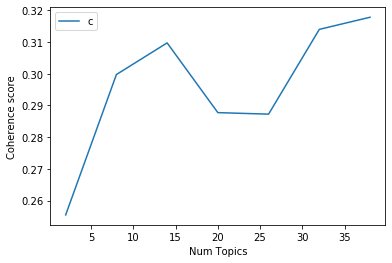

In [22]:
import os 
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME': r'C:/Users/Isabelle/Downloads/mallet-2.0.8/mallet-2.0.8/'})
mallet_path = 'C:\\Users\\Isabelle\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2555
Num Topics = 8  has Coherence Value of 0.2997
Num Topics = 14  has Coherence Value of 0.3097
Num Topics = 20  has Coherence Value of 0.2877
Num Topics = 26  has Coherence Value of 0.2872
Num Topics = 32  has Coherence Value of 0.314
Num Topics = 38  has Coherence Value of 0.3178


In [24]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.031*"droit" + 0.021*"travail" + 0.020*"faire" + 0.019*"retraite" + '
  '0.015*"rie" + 0.013*"maladie" + 0.012*"droite" + 0.011*"http" + '
  '0.011*"personne" + 0.010*"payer" + 0.009*"tout" + 0.009*"donc" + '
  '0.009*"fois" + 0.009*"oui" + 0.009*"caisse"'),
 (1,
  '0.044*"suisse" + 0.031*"fédéral" + 0.014*"accord" + 0.011*"conseil" + '
  '0.009*"élection" + 0.008*"cadre" + 0.008*"udc" + 0.008*"étranger" + '
  '0.008*"politique" + 0.008*"pays" + 0.008*"devoir" + 0.007*"asile" + '
  '0.007*"immigration" + 0.007*"faire" + 0.007*"maintenant"'),
 (2,
  '0.034*"bon" + 0.025*"aller" + 0.018*"moins" + 0.015*"service" + '
  '0.014*"fédéral" + 0.013*"etat" + 0.012*"excellent" + 0.012*"déjà" + '
  '0.012*"petit" + 0.011*"bel" + 0.011*"voir" + 0.010*"raison" + 0.010*"très" '
  '+ 0.010*"autre" + 0.010*"là"'),
 (3,
  '0.019*"hui" + 0.017*"politique" + 0.016*"voter" + 0.016*"initiative" + '
  '0.015*"fédéral" + 0.014*"national" + 0.013*"oui" + 0.013*"femme" + '
  '0.013*"engager" + 0.013*"

In [26]:
optimal_model.save('models/Twitter_models/LDAMallet_14topics.model')